# Imports

In [0]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

# uncomment when not using DataBricks
# spark = SparkSession \
#     .builder \
#     .master("local[*]") \
#     .appName("Pipeline") \
#     .getOrCreate()

# sc = spark.sparkContext

# Reading CSV data

In [0]:
train_identity_dataset = "/mnt/nottateam/train_identity.csv"
train_transaction_dataset = "/mnt/nottateam/train_transaction.csv"
test_identity_dataset = "/mnt/nottateam/test_identity.csv"
test_transaction_dataset = "/mnt/nottateam/test_transaction.csv"

# load the transaction and identity datasets for both training and testing
train_identity = spark.read.options(header=True, inferSchema=True).csv(train_identity_dataset)
train_transac = spark.read.options(header=True, inferSchema=True).csv(train_transaction_dataset)

test_identity = spark.read.options(header=True, inferSchema=True).csv(test_identity_dataset)
test_transac = spark.read.options(header=True, inferSchema=True).csv(test_transaction_dataset)

# merge transaction and identity datasets
train_set = train_transac.join(train_identity, on="TransactionID",how="left")
test_set = test_transac.join(test_identity, on="TransactionID",how="left")

# split to fraudulent and normal transactions
fraud_cases = train_set.filter(train_set.isFraud==1)
nonfraud_cases = train_set.filter(train_set.isFraud==0)

# randomly sample a small subset of the fraud and non-fraud transaction instances (~500 each) for validation dataset
val_set = nonfraud_cases.sample(500/nonfraud_cases.count())
val_set = val_set.union(fraud_cases.sample(500/fraud_cases.count()))
train_set = fraud_cases.subtract(val_set)
val_set.cache()
# get the ground truth
gt = val_set.select('isFraud').rdd.map(lambda x : list(x)[0]).collect()

# Dataset Cleaning

We are only focusing on the fraud part of the dataset. 

For this part, we clean the strings columns by removing redundant string columns and cleaning columns containing more than 10 unique string values. Next, we convert the all remaining NaN values into 0.

The output of this step will be passed into the feature extraction part.

In [0]:
# retrieve string columns
string_cols = sc.parallelize(train_set.dtypes).filter(lambda x: x[1]=='string').map(lambda x:x[0]).collect()


# change the columns of test dataset to be consistent with train dataset
test_set = test_set.withColumnRenamed("id-01", "id_01").withColumnRenamed("id-02", "id_02").withColumnRenamed("id-03", "id_03").withColumnRenamed("id-04", "id_04").withColumnRenamed("id-05", "id_05").withColumnRenamed("id-06", "id_06").withColumnRenamed("id-07", "id_07").withColumnRenamed("id-08", "id_08").withColumnRenamed("id-09", "id_09").withColumnRenamed("id-10", "id_10").withColumnRenamed("id-11", "id_11").withColumnRenamed("id-12", "id_12").withColumnRenamed("id-13", "id_13").withColumnRenamed("id-14", "id_14").withColumnRenamed("id-15", "id_15").withColumnRenamed("id-16", "id_16").withColumnRenamed("id-17", "id_17").withColumnRenamed("id-18", "id_18").withColumnRenamed("id-19", "id_19").withColumnRenamed("id-20", "id_20").withColumnRenamed("id-21", "id_21").withColumnRenamed("id-22", "id_22").withColumnRenamed("id-23", "id_23").withColumnRenamed("id-24", "id_24").withColumnRenamed("id-25", "id_25").withColumnRenamed("id-26", "id_26").withColumnRenamed("id-27", "id_27").withColumnRenamed("id-28", "id_28").withColumnRenamed("id-29", "id_29").withColumnRenamed("id-30", "id_30").withColumnRenamed("id-31", "id_31").withColumnRenamed("id-32", "id_32").withColumnRenamed("id-33", "id_33").withColumnRenamed("id-34", "id_34").withColumnRenamed("id-35", "id_35").withColumnRenamed("id-36", "id_36").withColumnRenamed("id-37", "id_37").withColumnRenamed("id-38", "id_38")

# retrieve string columns
string_cols_test = sc.parallelize(test_set.dtypes).filter(lambda x: x[1]=='string').map(lambda x:x[0]).collect()

### Convert TransactionDT column

Additionally, we want to convert the TransactionDT into the time difference relative to the "start of the day".

In [0]:
train_set = train_set.withColumn('TransactionDT', train_set['TransactionDT']%86400)  # there are 86400 seconds in a day

val_set = val_set.withColumn('TransactionDT', val_set['TransactionDT']%86400)

test_set = test_set.withColumn('TransactionDT', test_set['TransactionDT']%86400)

### Dealing with string columns

In [0]:
from pyspark.sql.functions import isnan, when, count, col

# fill NaN or null values with "N/A" for string columns to indicate the data is not available
train_set = train_set.na.fill("N/A", subset=string_cols)

# validation dataset
val_set = val_set.na.fill("N/A", subset=string_cols)

# test dataset
test_set = test_set.na.fill("N/A", subset=string_cols_test)

In [0]:
from pyspark.sql.functions import regexp_replace

# reduce the instances for these columns
email_domains = ['gmail','hotmail', 'yahoo', 'outlook', 'icloud', 'live', 'msn', 'anonymous', 'N/A']
browsers = ['chrome|google', 'firefox', 'opera', 'edge', 'ie', 'safari', 'N/A']
os = ['Windows 10', 'Windows .*', 'iOS 11.*', 'iOS .*', '(Android 7|Android 8).*', 'Android .*', '(Mac OS X 10(_\.)12|Mac OS X 10(_\.)13).*', 'Mac OS X.*']

# training dataset

# P_emaildomain
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[0]+'.*', 'gmail'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[1]+'.*', 'hotmail'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[2]+'.*', 'yahoo'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[3]+'.*', 'microsoft'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[5]+'.*', 'microsoft'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[6]+'.*', 'microsoft'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[4]+'.*', 'icloud'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[7]+'.*', 'anonymous'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[8]+'.*', 'unknown'))
train_set = train_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))


# R_emaildomain
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[0]+'.*', 'gmail'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[1]+'.*', 'hotmail'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[2]+'.*', 'yahoo'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[3]+'.*', 'microsoft'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[5]+'.*', 'microsoft'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[6]+'.*', 'microsoft'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[4]+'.*', 'icloud'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[7]+'.*', 'anonymous'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[8]+'.*', 'unknown'))
train_set = train_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))

# id_30
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[0], 'windows_latest'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[1], 'windows_others'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[2], 'ios_latest'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[3], 'ios_others'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[4], 'android_latest'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[5], 'android_others'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[6], 'macos_latest'))
train_set = train_set.withColumn('id_30', regexp_replace('id_30', os[7], 'macos_others'))
os_new = ['windows_latest', 'windows_others', 'ios_latest', 'ios_others', 'android_latest', 'android_others', 'macos_latest', 'macos_others']
train_set = train_set.withColumn('id_30', regexp_replace('id_30', '^((?!'+'|'.join(os_new)+').)*$', 'unknown'))

# id_31
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[0]+').*', 'chrome'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[1]+').*', 'firefox'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[2]+').*', 'opera'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[3]+').*', 'edge'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[4]+').*', 'ie'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[5]+').*', 'safari'))
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[6]+').*', 'unknown'))
browser_new = ['chrome','firefox','opera','edge','ie','safari','unknown']
train_set = train_set.withColumn('id_31', regexp_replace('id_31', '^((?!'+'|'.join(browser_new)+').)*$', 'others'))


In [0]:
# validation dataset

email_domains = ['gmail','hotmail', 'yahoo', 'outlook', 'icloud', 'live', 'msn', 'anonymous', 'N/A']
browsers = ['chrome|google', 'firefox', 'opera', 'edge', 'ie', 'safari', 'N/A']
os = ['Windows 10', 'Windows .*', 'iOS 11.*', 'iOS .*', '(Android 7|Android 8).*', 'Android .*', '(Mac OS X 10(_\.)12|Mac OS X 10(_\.)13).*', 'Mac OS X.*']


# P_emaildomain
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[0]+'.*', 'gmail'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[1]+'.*', 'hotmail'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[2]+'.*', 'yahoo'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[3]+'.*', 'microsoft'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[5]+'.*', 'microsoft'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[6]+'.*', 'microsoft'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[4]+'.*', 'icloud'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[7]+'.*', 'anonymous'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[8]+'.*', 'unknown'))
val_set = val_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))


# R_emaildomain
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[0]+'.*', 'gmail'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[1]+'.*', 'hotmail'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[2]+'.*', 'yahoo'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[3]+'.*', 'microsoft'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[5]+'.*', 'microsoft'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[6]+'.*', 'microsoft'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[4]+'.*', 'icloud'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[7]+'.*', 'anonymous'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[8]+'.*', 'unknown'))
val_set = val_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))

# id_30
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[0], 'windows_latest'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[1], 'windows_others'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[2], 'ios_latest'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[3], 'ios_others'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[4], 'android_latest'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[5], 'android_others'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[6], 'macos_latest'))
val_set = val_set.withColumn('id_30', regexp_replace('id_30', os[7], 'macos_others'))
os_new = ['windows_latest', 'windows_others', 'ios_latest', 'ios_others', 'android_latest', 'android_others', 'macos_latest', 'macos_others']
val_set = val_set.withColumn('id_30', regexp_replace('id_30', '^((?!'+'|'.join(os_new)+').)*$', 'unknown'))

# id_31
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[0]+').*', 'chrome'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[1]+').*', 'firefox'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[2]+').*', 'opera'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[3]+').*', 'edge'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[4]+').*', 'ie'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[5]+').*', 'safari'))
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[6]+').*', 'unknown'))
browser_new = ['chrome','firefox','opera','edge','ie','safari','unknown']
val_set = val_set.withColumn('id_31', regexp_replace('id_31', '^((?!'+'|'.join(browser_new)+').)*$', 'others'))


In [0]:
# test dataset

# P_emaildomain
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[0]+'.*', 'gmail'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[1]+'.*', 'hotmail'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[2]+'.*', 'yahoo'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[3]+'.*', 'microsoft'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[5]+'.*', 'microsoft'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[6]+'.*', 'microsoft'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[4]+'.*', 'icloud'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[7]+'.*', 'anonymous'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', email_domains[8]+'.*', 'unknown'))
test_set = test_set.withColumn('P_emaildomain', regexp_replace('P_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))


# R_emaildomain
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[0]+'.*', 'gmail'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[1]+'.*', 'hotmail'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[2]+'.*', 'yahoo'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[3]+'.*', 'microsoft'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[5]+'.*', 'microsoft'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[6]+'.*', 'microsoft'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[4]+'.*', 'icloud'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[7]+'.*', 'anonymous'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', email_domains[8]+'.*', 'unknown'))
test_set = test_set.withColumn('R_emaildomain', regexp_replace('R_emaildomain', '^((?!'+'|'.join(email_domains)+').)*$', 'others'))

# id_30
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[0], 'windows_latest'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[1], 'windows_others'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[2], 'ios_latest'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[3], 'ios_others'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[4], 'android_latest'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[5], 'android_others'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[6], 'macos_latest'))
test_set = test_set.withColumn('id_30', regexp_replace('id_30', os[7], 'macos_others'))
os_new = ['windows_latest', 'windows_others', 'ios_latest', 'ios_others', 'android_latest', 'android_others', 'macos_latest', 'macos_others']
test_set = test_set.withColumn('id_30', regexp_replace('id_30', '^((?!'+'|'.join(os_new)+').)*$', 'unknown'))

# id_31
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[0]+').*', 'chrome'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[1]+').*', 'firefox'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[2]+').*', 'opera'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[3]+').*', 'edge'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[4]+').*', 'ie'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[5]+').*', 'safari'))
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '.*('+browsers[6]+').*', 'unknown'))
browser_new = ['chrome','firefox','opera','edge','ie','safari','unknown']
test_set = test_set.withColumn('id_31', regexp_replace('id_31', '^((?!'+'|'.join(browser_new)+').)*$', 'others'))


### Exclude columns that are considered "redundant" (string columns)

In [0]:
train_set = train_set.select([c for c in train_set.columns if c not in {'id_33','DeviceInfo'}])

val_set = val_set.select([c for c in val_set.columns if c not in {'id_33','DeviceInfo'}])

test_set = test_set.select([c for c in test_set.columns if c not in {'id_33','DeviceInfo'}])

### use string indexer to convert categorical data into numerical data

In [0]:
from pyspark.ml.feature import StringIndexer

# remove the excluded columns as they do not exist in dataset anymore
del string_cols[string_cols.index('id_33')]
del string_cols[string_cols.index('DeviceInfo')]

# train dataset
# convert the string columns into numerical columns
index_cols = [c+'indexed' for c in string_cols]
stringIndexer = StringIndexer(inputCols=string_cols, outputCols=index_cols)
model = stringIndexer.fit(train_set)
result = model.transform(train_set)


# validation dataset
# convert to numerial columns with the string indexer from train dataset
result_val = model.transform(val_set)


# test dataset
# remove the excluded columns as they do not exist in dataset anymore
del string_cols_test[string_cols_test.index('id_33')]
del string_cols_test[string_cols_test.index('DeviceInfo')]

# convert the string columns into numerical columns
index_cols = [c+'indexed' for c in string_cols_test]
stringIndexer = StringIndexer(inputCols=string_cols_test, outputCols=index_cols)
model = stringIndexer.fit(test_set)
result_test = model.transform(test_set)

### Exclude columns that are "redundant" (all columns)

In [0]:
# we also want to remove isFraud and TransactionID as they do not serve any purpose for our feature extraction
train_set = result.select([c for c in result.columns if c not in string_cols+['isFraud']])

val_set = result_val.select([c for c in result_val.columns if c not in string_cols+['isFraud', 'TransactionID']])

# test dataset
test_transactionid = result_test.select(['TransactionID']).rdd.map(lambda x : list(x)[0]).collect() # reserve for submission to Kaggle
test_set = result_test.select([c for c in result_test.columns if c not in string_cols+['TransactionID']])

In [0]:
# fill in NaN values
train_set = train_set.na.fill(0)

val_set = val_set.na.fill(0)

test_set = test_set.na.fill(0)

### Assemble dataframe and normalize for PCA

In [0]:
# prepare the assembler model
cols = train_set.columns
del cols[cols.index("TransactionID")]
assemble = VectorAssembler(inputCols=cols, outputCol='features')

# train dataset
assembled_data_train = assemble.transform(train_set).select(['features', 'TransactionID'])

# validation dataset
assembled_data_val = assemble.transform(val_set).select(['features'])

# test dataset
assembled_data_test = assemble.transform(test_set).select(['features'])

### Reserve half of the train dataset for phase 2

In [0]:
assembled_data_train, reserved = assembled_data_train.randomSplit([0.5,0.5])

# PCA

###PCA Process

In [0]:
pca = PCA(k=3, inputCol="features", outputCol="pca_features") # first 3 dimensions has cummulative variance of ~99.8%

# train dataset
model = pca.fit(assembled_data_train)
pca_features_train = model.transform(assembled_data_train).select(["pca_features", "TransactionID"])
pca_features_reserved = model.transform(reserved).select(["pca_features", "TransactionID"])

# val dataset
pca_features_val = model.transform(assembled_data_val).select("pca_features")

# test
# fitting the test datast using PCs from train set
pca_features_test = model.transform(assembled_data_test).select("pca_features") 

### Normalize PCA output

In [0]:
from pyspark.ml.feature import StandardScaler, RobustScaler

# train dataset
scaler = RobustScaler(inputCol="pca_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(pca_features_train)
scaled_data_train = scalerModel.transform(pca_features_train)

scale = StandardScaler(inputCol='scaledFeatures', outputCol='standardized')
data_scale = scale.fit(scaled_data_train)
data_scale_output_train = data_scale.transform(scaled_data_train).select(['standardized', 'TransactionID'])

scaled_data_reserved = scalerModel.transform(pca_features_reserved)
data_scale_output_reserve = data_scale.transform(scaled_data_reserved).select(['standardized', 'TransactionID'])

# validation dataset
scaled_data_val = scalerModel.transform(pca_features_val)
data_scale_output_val = data_scale.transform(scaled_data_val).select(['standardized'])

# test dataset
scaled_data_test = scalerModel.transform(pca_features_test)
data_scale_output_test = data_scale.transform(scaled_data_test).select(['standardized'])

# K-means clustering

### Find optimal number of clusters with silhouette score

In [0]:
# we perform k-means clustering from the range [2, 20) to find the best number of clusters to use
# silhouette score is used as the metric, it ranges from [-1, 1], and generally the higher the better as the clusters are farther apart

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = [] # log silhouette score for plotting
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,20):
    # prepare the k-means model and train in train dataset
    KMeans_algo = KMeans(featuresCol='standardized', k=i, maxIter=100)
    KMeans_fit = KMeans_algo.fit(data_scale_output_train)
    output = KMeans_fit.transform(data_scale_output_train)
    
    # evaluate and log the silhouette score
    score = evaluator.evaluate(output)
    # silhouette score explanation: https://stats.stackexchange.com/a/44653
    silhouette_score.append(score)

    print("Clusters:", i)
    print("Silhouette Score:", score)

Clusters: 2
Silhouette Score: 0.5470906026903044
Clusters: 3
Silhouette Score: 0.6366126580876038
Clusters: 4
Silhouette Score: 0.7306472340462423
Clusters: 5
Silhouette Score: 0.6924105942464966
Clusters: 6
Silhouette Score: 0.6843963467441112
Clusters: 7
Silhouette Score: 0.6842700331003394
Clusters: 8
Silhouette Score: 0.6130577934400537
Clusters: 9
Silhouette Score: 0.6133824712354957
Clusters: 10
Silhouette Score: 0.614910217354675
Clusters: 11
Silhouette Score: 0.6055487042078582
Clusters: 12
Silhouette Score: 0.5899215037176138
Clusters: 13
Silhouette Score: 0.5652396660814264
Clusters: 14
Silhouette Score: 0.570759208466083
Clusters: 15
Silhouette Score: 0.568158567562667
Clusters: 16
Silhouette Score: 0.5884168838519465
Clusters: 17
Silhouette Score: 0.5671529618578129
Clusters: 18
Silhouette Score: 0.5867366329246999
Clusters: 19
Silhouette Score: 0.5927660928743379

Out[18]:

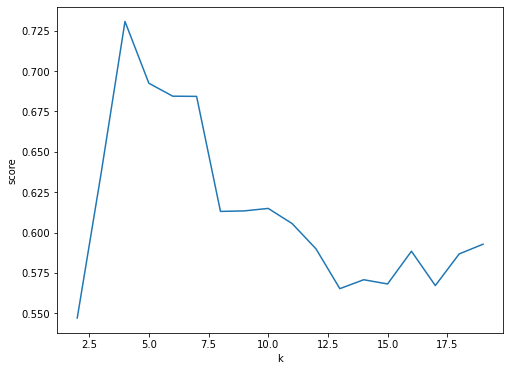

Text(0, 0.5, 'score')

In [0]:
# Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(range(2,20), silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('score')

### Train the K-means with the optimal number of clusters

In [0]:
# once we know the optimal number of clusters, we can get the number of instances for each cluster

from pyspark.mllib.clustering import KMeans

initial_instances = data_scale_output_train.rdd.map(lambda x : np.array(x[0]))

k = 4 # no. of clusters
model = KMeans.train(
              initial_instances, k, maxIterations=100, initializationMode="random",
              seed=50, initializationSteps=5, epsilon=1e-4)

cluster_ind = model.predict(initial_instances)
# cluster_ind.collect()  # shows for each instance which class it is closest to

# Building the initial model

1. Calculate the radius for each cluster centre
2. For each instance in the training dataset (that are not reserved), calculate their distance to each cluster centre
3. If an instance falls within the radius of a cluster centre, it is removed. The remaining instances are kept, and assigned a radius to it

In [0]:
# get, for each cluster, the number of instances that belong to that cluster (cluster, num_instances)
cluster_sizes = list(cluster_ind.countByValue().items())
cluster_sizes

Out[20]: [(0, 4822), (2, 2993), (3, 1470), (1, 734)]

In [0]:
# this step basically keeps broadcasted data in cache
# broadcast the cluster centres to be used in building the initial model 
centers = np.array(model.clusterCenters)
broadcasted_centers = sc.broadcast(centers)

In [0]:
# calculate radius and margin
num_instances = sum([x[1] for x in cluster_sizes])

alpha = 1.2  # parameter for adjusting the size of radius
radius = [t[1]/num_instances*alpha for t in cluster_sizes]
radius

Out[22]: [0.5775426689290348,
 0.35847889010879325,
 0.1760654755963669,
 0.08791296536580497]

In [0]:
# reformat to cluster centres to include other information, then broadcast them
cluster_means = [(c, radius[i]) for i,c in enumerate(centers)]
broadcasted_means = sc.broadcast(cluster_means)

In [0]:
def calc_dist(instance):
  # calculate and return the euclidean distance
  return np.sum((broadcasted_centers.value - instance)**2, axis=1) ** 0.5

def flag_instances(instance):
  # calculate the distance from the instance to each cluster centre
  distances = calc_dist(instance)
  if any([d <= v for d,v in zip(distances, radiuses)]):
    remove = 1
  else:
    remove = 0
  
  return remove # flag whether to exclude the instance or not from the model


# convert to rdd
phase_1 = data_scale_output_train.rdd.map(lambda x : (np.array(x[0]), x[1]))
reserved = data_scale_output_reserve.rdd.map(lambda x : (np.array(x[0]), x[1]))

radiuses = [v[1] for v in broadcasted_means.value]
# calculate, for each fraudulent instance in our train dataset, the distance between it and each cluster centre
euclid_dist = phase_1.map(lambda x : (flag_instances(x[0]), *x)) # (flag, instance, ID)
num_instances = phase_1.count()

In [0]:
# remove fraudulent instances that are within radius of any cluster centre as they are "redundant"
remaining_instances = euclid_dist.filter(lambda x : x[0]==0).map(lambda x : (x[1], x[2])) # (instance, ID)

In [0]:
model_instances_only = remaining_instances.map(lambda x : x[0]).collect() # retrieve only the instance (without the additional information)

# broadcast the model
model_instances = sc.broadcast(remaining_instances.collect())
model_instances_only = sc.broadcast(model_instances_only) # additionally broadcast the model instances only (without the additional information) for calculating distance between it and the incoming reserved fraudulent instances


#Phase 2

1. The reserved instances are used here to improve the model. The reserved instances are split into batches
2. For each new instance in each batch of size B, if it is within radius of a cluster centre, it is removed
3. Otherwise, assign a radius r, and all model instances that fall within radius of the new instance are merged with the new instance (by taking the mean instance of all the instances)
3. The merged instance is then added to the model, and the model instances that are merged are removed from the model

In [0]:
def calc_dist_instances(x):
  # calculate and return the euclidean distance
  dist = np.sum((model_instances_only.value - x[0])**2, axis=1) ** 0.5
  return (*x, dist) # (instance, ID, array_of_dist)


def group_neighbouring_instances(x):
  # group instances that are within radius of the new instance
  neighbouring_instances = [d<=radius for d in x[-1]]
  overlapped_instances = [(x[1],(*v,1)) for i,v in enumerate(model_instances.value) if neighbouring_instances[i]]
  # include the new instance itself (for merging later)
  combined = [(x[1], (x[0], x[1], 1))] + overlapped_instances
  return combined # list of instances, each instance (ID_x, (instance, ID_model, 1))





# assign radius for each new instance
radius = 0.02

# collect the reserved instances into drive as we want to compute by batches
res = reserved.collect()

batch_size = 50

batch_num = 1
for i in range(0, len(res), batch_size):
  print(i, "/", len(res))
  
  # retrieve the batch of instances and convert to rdd
  batch = res[i:i+batch_size]
  batch = sc.parallelize(batch) # (instance, ID)
  
  # first, check and see if instance is within radius of ANY cluster centre
  batch = batch.map(lambda x : (calc_dist(x[0]), *x)) # ([dist], instance, ID)
  batch = batch.filter(lambda x : not any([d <= v[1] for d,v in zip(x[0], broadcasted_means.value)]))
  if batch.isEmpty():
    # this means all instances here fall inside the radius of the cluster centres, we can ignore this batch
    continue
  
  batch = batch.map(lambda x : (x[1], x[2])) # (instance, ID)
  
  # then, calculate distance between a new instance and all model instances
  batch = batch.map(lambda x : calc_dist_instances(x)) # (instance, ID, [dist])
  
  # retrieve model instances to be grouped with the new instance
  grouped_instances = batch.flatMap(lambda x : group_neighbouring_instances(x)) # (ID_x, (instance, ID_model, 1)), (includes itself)
  
  # mark model instances to be removed
  remove_id = grouped_instances.map(lambda x : x[1][1])
  instances_to_remove = set(remove_id.collect())
  
  # merge the grouped instances
  merged = grouped_instances.reduceByKey(lambda x,y : x+y) # (ID_x, (combined_instance, _, num_instances))
  updated_instances = merged.map(lambda x : (x[1][0]/x[1][2], x[0])).collect() # (I, id)
  
  # update the model and broadcast it
  updated_model = [instance for instance in model_instances.value if instance[1] not in instances_to_remove] + updated_instances
  updated_model_instance_only = [instance[0] for instance in updated_model]
  
  # broadcast the model
  model_instances = sc.broadcast(updated_model)
  model_instances_only = sc.broadcast(updated_model_instance_only)


0 / 10137
50 / 10137
100 / 10137
150 / 10137
200 / 10137
250 / 10137
300 / 10137
350 / 10137
400 / 10137
450 / 10137
500 / 10137
550 / 10137
600 / 10137
650 / 10137
700 / 10137
750 / 10137
800 / 10137
850 / 10137
900 / 10137
950 / 10137
1000 / 10137
1050 / 10137
1100 / 10137
1150 / 10137
1200 / 10137
1250 / 10137
1300 / 10137
1350 / 10137
1400 / 10137
1450 / 10137
1500 / 10137
1550 / 10137
1600 / 10137
1650 / 10137
1700 / 10137
1750 / 10137
1800 / 10137
1850 / 10137
1900 / 10137
1950 / 10137
2000 / 10137
2050 / 10137
2100 / 10137
2150 / 10137
2200 / 10137
2250 / 10137
2300 / 10137
2350 / 10137
2400 / 10137
2450 / 10137
2500 / 10137
2550 / 10137
2600 / 10137
2650 / 10137
2700 / 10137
2750 / 10137
2800 / 10137
2850 / 10137
2900 / 10137
2950 / 10137
3000 / 10137
3050 / 10137
3100 / 10137
3150 / 10137
3200 / 10137
3250 / 10137
3300 / 10137
3350 / 10137
3400 / 10137
3450 / 10137
3500 / 10137
3550 / 10137
3600 / 10137
3650 / 10137
3700 / 10137
3750 / 10137
3800 / 10137
3850 / 10137
3900 / 10137
3950 / 10137
4000 / 10137
4050 / 10137
4100 / 10137
4150 / 10137
4200 / 10137
4250 / 10137
4300 / 10137
4350 / 10137
4400 / 10137
4450 / 10137
4500 / 10137
4550 / 10137
4600 / 10137
4650 / 10137
4700 / 10137
4750 / 10137
4800 / 10137
4850 / 10137
4900 / 10137
4950 / 10137
5000 / 10137
5050 / 10137
5100 / 10137
5150 / 10137
5200 / 10137
5250 / 10137
5300 / 10137
5350 / 10137
5400 / 10137
5450 / 10137
5500 / 10137
5550 / 10137
5600 / 10137
5650 / 10137
5700 / 10137
5750 / 10137
5800 / 10137
5850 / 10137
5900 / 10137
5950 / 10137
6000 / 10137
6050 / 10137
6100 / 10137
6150 / 10137
6200 / 10137
6250 / 10137
6300 / 10137
6350 / 10137
6400 / 10137
6450 / 10137
6500 / 10137
6550 / 10137
6600 / 10137
6650 / 10137
6700 / 10137
6750 / 10137
6800 / 10137
6850 / 10137
6900 / 10137
6950 / 10137
7000 / 10137
7050 / 10137
7100 / 10137
7150 / 10137
7200 / 10137
7250 / 10137
7300 / 10137
7350 / 10137
7400 / 10137
7450 / 10137
7500 / 10137
7550 / 10137
7600 / 10137
7650 / 10137
7700 / 10137
7750 / 10137
7800 / 10137
7850 / 10137
7900 / 10137
7950 / 10137
8000 / 10137
8050 / 10137
8100 / 10137
8150 / 10137
8200 / 10137
8250 / 10137
8300 / 10137
8350 / 10137
8400 / 10137
8450 / 10137
8500 / 10137
8550 / 10137
8600 / 10137
8650 / 10137
8700 / 10137
8750 / 10137
8800 / 10137
8850 / 10137
8900 / 10137
8950 / 10137
9000 / 10137
9050 / 10137
9100 / 10137
9150 / 10137
9200 / 10137
9250 / 10137
9300 / 10137
9350 / 10137
9400 / 10137
9450 / 10137
9500 / 10137
9550 / 10137
9600 / 10137
9650 / 10137
9700 / 10137
9750 / 10137
9800 / 10137
9850 / 10137
9900 / 10137
9950 / 10137
10000 / 10137
10050 / 10137
10100 / 10137

In [0]:
# get model size

len(model_instances.value)

Out[28]: 5226

#Classify test instances

1. The distance between each incoming instance and each cluster centre is calculated
2. If an incoming instances falls within radius of a cluster centre, it is considered as fraudulent
3. Otherwise, a radius is set to threshold "nearby" model instances to the incoming instance
4. If any model instance falls within radius of the incoming instance, the instance is considered as fraudulent
5. Otherwise, it is considered as non-fraudulent

###Validation set

In [0]:
val_instances = data_scale_output_val.select(['standardized']).rdd.map(lambda x : np.array(x[0]))

def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1, x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1
  else:
    return 0


radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)
  
# first, assign all instances within radius of ANY cluster centre with 1.
val_instances = val_instances.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY model instances with 1.
# assign 0. for the rest
predictions = val_instances.map(lambda x : near_model_instances(x)).collect()

# flip prediction around because anti-learning
predictions = [0 if i == 1 else 1 for i in predictions]

score = [a==b for a,b in zip(gt, predictions)]
print(sum(score)/len(gt)*100, "%")

57.2139303482587 %

### Test set

In [0]:
test_instances = data_scale_output_test.select(['standardized']).rdd.map(lambda x : np.array(x[0]))

def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.

  
radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances = test_instances.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances.map(lambda x : near_model_instances(x)).collect()

# create a new dataframe to upload to Kaggle for AUROC score
submission = pd.DataFrame({'TransactionID': test_transactionid, 'isFraud': predictions})

In [0]:
# display and download the prediction dataframe, then submit it to https://www.kaggle.com/c/ieee-fraud-detection/submit for AUROC score

submission_sp = spark.createDataFrame(submission)
display(submission_sp)

TransactionID,isFraud
3663549,1.0
3663550,1.0
3663551,1.0
3663552,1.0
3663553,1.0
3663554,0.0
3663555,1.0
3663556,1.0
3663557,0.0
3663558,1.0


# Test on varying batch size for Phase 2

### Artificially increase the number of reserved instances to 100,000 with SMOTE

In [0]:
# SMOTE code adopted from: https://github.com/Angkirat/Smote-for-Spark

from sklearn import neighbors
import random
from pyspark.sql import Row

def SmoteSampling(vectorized, k=5, percentageOver=200):
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    feature = vectorized.select('standardized')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = vectorized.rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver//100
    start_idx = 4000000+1
    count = 0
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec, start_idx+count))
            count += 1
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(standardized = x[0], TransactionID = x[1]))
    new_data = newData_rdd_new.toDF()
    
    new_data_minor = vectorized.unionAll(new_data)
    return new_data_minor


new_synthetic_instances = data_scale_output_reserve.union(data_scale_output_train)
new_synthetic_instances_smoted = SmoteSampling(new_synthetic_instances.select(['standardized', 'TransactionID']), percentageOver=400)

reserved = new_synthetic_instances_smoted.rdd.map(lambda x : (np.array(x[0]), x[1]))

### Reset the initial model

In [0]:
model_instances_only = remaining_instances.map(lambda x : x[0]).collect() # retrieve only the instance (without the additional information)

# broadcast the model
model_instances = sc.broadcast(remaining_instances.collect())
model_instances_only = sc.broadcast(model_instances_only) # additionally broadcast the model instances only (without the additional information) for calculating distance between it and the incoming reserved fraudulent instances


### Phase 2

In [0]:
def calc_dist_instances(x):
  # calculate and return the euclidean distance
  dist = np.sum((model_instances_only.value - x[0])**2, axis=1) ** 0.5
  return (*x, dist) # (instance, ID, array_of_dist)


def group_neighbouring_instances(x):
  # group instances that are within radius of the new instance
  neighbouring_instances = [d<=radius for d in x[-1]]
  overlapped_instances = [(x[1],(*v,1)) for i,v in enumerate(model_instances.value) if neighbouring_instances[i]]
  # include the new instance itself (for merging later)
  combined = [(x[1], (x[0], x[1], 1))] + overlapped_instances
  return combined # list of instances, each instance (ID_x, (instance, ID_model, 1))





# assign radius for each new instance
radius = 0.02

# collect the reserved instances into drive as we want to compute by batches
res = reserved.collect()[:100000]

batch_size = 100000 # 1, 50, 200, 1000, 5000, 10000, 100000

phase_2_time = time.time()
batch_num = 1
for i in range(0, len(res), batch_size):
  print(i, "/", len(res))
  
  # retrieve the batch of instances and convert to rdd
  batch = res[i:i+batch_size]
  batch = sc.parallelize(batch) # (instance, ID)
  
  # first, check and see if instance is within radius of ANY cluster centre
  batch = batch.map(lambda x : (calc_dist(x[0]), *x)) # ([dist], instance, ID)
  batch = batch.filter(lambda x : not any([d <= v[1] for d,v in zip(x[0], broadcasted_means.value)]))
  if batch.isEmpty():
    # this means all instances here fall inside the radius of the cluster centres, we can ignore this batch
    continue
  
  batch = batch.map(lambda x : (x[1], x[2])) # (instance, ID)
  
  # then, calculate distance between a new instance and all model instances
  batch = batch.map(lambda x : calc_dist_instances(x)) # (instance, ID, [dist])
  
  # retrieve model instances to be grouped with the new instance
  grouped_instances = batch.flatMap(lambda x : group_neighbouring_instances(x)) # (ID_x, (instance, id_model, 1)), (includes itself)
  
  # mark model instances to be removed
  remove_id = grouped_instances.map(lambda x : x[1][1])
  instances_to_remove = set(remove_id.collect())
  
  # merge the grouped instances
  merged = grouped_instances.reduceByKey(lambda x,y : x+y) # (ID_x, (combined_instance, _, num_instances))
  updated_instances = merged.map(lambda x : (x[1][0]/x[1][2], x[0])).collect() # (instance, ID)
  
  # update the model and broadcast it
  updated_model = [instance for instance in model_instances.value if instance[1] not in instances_to_remove] + updated_instances
  updated_model_instance_only = [instance[0] for instance in updated_model]
  
  # broadcast the model
  model_instances = sc.broadcast(updated_model)
  model_instances_only = sc.broadcast(updated_model_instance_only)
  
  
  print("Avg processing time:", (time.time()-phase_2_time)/batch_num)
  batch_num += 1

print("Time taken for phase 2:", time.time()-phase_2_time)

# Test on varying test dataset size for classification

### Artificially resize test dataset

In [0]:
# convert the validation test instances to rdd
test_instances = data_scale_output_test.select(['standardized']).rdd.map(lambda x : np.array(x[0])) # 506691
test_instances_1000 = test_instances.sample(False, 1000/test_instances.count())
test_instances_5000 = test_instances.sample(False, 5000/test_instances.count())
test_instances_50000 = test_instances.sample(False, 50000/test_instances.count())
test_instances_500000 = test_instances.sample(False, 500000/test_instances.count())
test_instances_5000000 = data_scale_output_test.union(data_scale_output_test) # ~1000000
test_instances_5000000 = test_instances_5000000.union(test_instances_5000000) # ~2000000
test_instances_5000000 = test_instances_5000000.union(test_instances_5000000) # ~4000000
test_instances_5000000 = test_instances_5000000.union(data_scale_output_test).union(data_scale_output_test) # ~5000000
test_instances_5000000 = test_instances_5000000.select(['standardized']).rdd.map(lambda x : np.array(x[0])).sample(False, 5000000/test_instances.count())

### 1000 instances

In [0]:
def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.



radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# log prediction time for validation dataset
test_prediction_time = time.time()

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances_1000 = test_instances_1000.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances_1000.map(lambda x : near_model_instances(x)).collect()

print("Test prediction time:", time.time()-test_prediction_time)


### 5000 instances

In [0]:
def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.



radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# log prediction time for validation dataset
test_prediction_time = time.time()

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances_5000 = test_instances_5000.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances_5000.map(lambda x : near_model_instances(x)).collect()

print("Test prediction time:", time.time()-test_prediction_time)


### 50000 instances

In [0]:
def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.



radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# log prediction time for validation dataset
test_prediction_time = time.time()

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances_50000 = test_instances_50000.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances_50000.map(lambda x : near_model_instances(x)).collect()

print("Test prediction time:", time.time()-test_prediction_time)


### 500000 instances

In [0]:
def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.



radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# log prediction time for validation dataset
test_prediction_time = time.time()

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances_500000 = test_instances_500000.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances_500000.map(lambda x : near_model_instances(x)).collect()

print("Test prediction time:", time.time()-test_prediction_time)


### 5000000 instances

In [0]:
def near_cluster_centre(x):
  # calculate the distance between the instance and each cluster centre, 
  # and decide if it is near enough to a cluster centre to be considered as fraudulent
  distance = calc_dist(x)
  if any([d < v[1] for d,v in zip(distance, broadcasted_means.value)]):
    return (1., x)
  else:
    return (-1, x)


def near_model_instances(x):
  # calculate the distance between the instance and each model instance, 
  # and decide if it is near enough to a model instance to be considered as fraudulent
  if x[0] > 0.5:
    return x[0]
  dist = np.sum((the_model_instances - x[1][0])**2, axis=1) ** 0.5
  if any([d <= radius for d in dist]):
    return 1.
  else:
    return 0.



radius = 0.01 # assign radius for each new instance

the_model_instances = np.array(model_instances_only.value)

# log prediction time for validation dataset
test_prediction_time = time.time()

# first, assign all instances within radius of ANY cluster centre with 1.
test_instances_5000000 = test_instances_5000000.map(lambda x : near_cluster_centre(x))

# assign all instances within radius of ANY remaining instances with 1.
# assign 0. for the rest
predictions = test_instances_5000000.map(lambda x : near_model_instances(x)).collect()

print("Test prediction time:", time.time()-test_prediction_time)
